In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader as web
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import argrelextrema
from sklearn.metrics import mean_squared_error
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

import warnings
warnings.filterwarnings('ignore')

def find_parameters_d_D(data, seasonal_component):
    d = 0
    D = 0
    data_diff = data
    X = data.values
    result = adfuller(X)

    while (result[1] >= 0.05 or result[1] <= -0.05):
        data_diff = data.diff().dropna()
        d += 1
        data_diff = data_diff.diff(seasonal_component).dropna()
        D += 1
        X = data_diff.values
        result = adfuller(X)
        
    return d, D, data_diff

def find_parameter_p(data):
    acf_data, conf_int = acf(data, nlags = 100, alpha = .05)
    p = 0
    for i in range(1, len(data), 1):
        p += 1
        conf_int[i][1] -= acf_data[i]
        conf_int[i][0] -= acf_data[i]
        if ((acf_data[i] > conf_int[i][1]) or (acf_data[i] < conf_int[i][0])):
            break
        else:
            continue
    return p

def find_parameter_q(data):
    pacf_data, conf_int = pacf(data, nlags = 100, alpha = .05)
    q = 0
    for i in range(1, len(data)):
        q += 1
        conf_int[i][1] -= pacf_data[i]
        conf_int[i][0] -= pacf_data[i]
        if ((pacf_data[i] > conf_int[i][1]) or (pacf_data[i] < conf_int[i][0])):
            break
        else:
            continue
    return q

def find_S(data):
    acf_data = acf(data, nlags = len(data))
    max_acf = 0
    
    for i in range(1, len(data)):
        if (abs(acf_data[i]) >= abs(max_acf)):
            max_acf = acf_data[i]
    if (max_acf > 0):
        sign = 'Positive'
    else:
        sign = 'Negative'
    return sign

def find_P_and_Q(data):
    sign = find_S(data)
    if (sign == 'Positive'):
        P, Q = 1, 0
        return P, Q
    else:
        P, Q = 0, 1
        return P, Q
    
def run_SARIMA(ticker, steps_to_forecast):
    
    df = web.DataReader(ticker, data_source='yahoo', start='2014-01-01', end= '2021-06-08')
    df = df.filter(['Close'])
    
    seasonality = 100
    d, D, df_diff = find_parameters_d_D(df, seasonality)
    p = find_parameter_p(df_diff)
    q = find_parameter_q(df_diff)
    P, Q = find_P_and_Q(df_diff)
    history = df[:int(len(df) - steps_to_forecast)].values
        
    model = SARIMAX(history, order = (p, d, q), 
                    seasonal_order = (P, D, Q, seasonality),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
    
    model_fit = model.fit(low_memory=True)
    pred_uc = model_fit.get_forecast(steps = steps_to_forecast)
    pred_ci = pred_uc.conf_int()
    return pred_uc, pred_ci

def find_file_id(ticker, drive):
    name = f'{ticker}_SARIMA_forecasts'
    file_list = drive.ListFile({'q': f"'1kxtGrwVl0gscMq79quvISHmXhUg4ZDUZ' in parents and trashed=false"}).GetList()
    if (len(file_list) != 0):
        for file in file_list:
            if (name == file['title']):
                print(file['title'])
                return file['id']
            else:
                continue
    return None
                
    
def upload_file(ticker, drive):
    upload_file = f'D:\Project\VSASMTA\data\{ticker}_SARIMA_forecasts.csv'
    file = drive.CreateFile({'parents': [{'id': '1kxtGrwVl0gscMq79quvISHmXhUg4ZDUZ'}],
                             "mimeType": "text/csv", 
                             "title" : f"{ticker}_SARIMA_forecasts"})
    file.SetContentFile(upload_file)
    file.Upload()
    
def update_file(ticker, drive, file_id):
    upload_file = f'D:\Project\VSASMTA\data\{ticker}_SARIMA_forecasts.csv'
    file = drive.CreateFile({'id' : f'{file_id}',
                             "mimeType": "text/csv", 
                             "title" : f'{ticker}_SARIMA_forecasts'})
    file.SetContentFile(upload_file)
    file.Upload()

In [29]:
n_step_forecast = int(input())

ticker_list = ('AAPL', 'MSFT', 'GOOG', 'GOOGL', 'FB', 'TSM', 'NVDA', 'ADBE', 'INTC', 'CSCO')

gauth = GoogleAuth()
gauth.LoadCredentialsFile("creds.txt")

if gauth.credentials is None:
    gauth.GetFlow()
    gauth.flow.params.update({'access_type': 'offline'})
    gauth.flow.params.update({'approval_prompt': 'force'})
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("creds.txt")  

drive = GoogleDrive(gauth)

for ticker in ticker_list:
    pred_uc, pred_ci = run_SARIMA(ticker, n_step_forecast) 
    df = web.DataReader(ticker, data_source='yahoo', start='2014-01-01', end= '2021-06-08')
    df = df.filter(['Close'])
    set_dates = df[int(len(df) - n_step_forecast):].index
    
    values = np.array([pred_uc.predicted_mean, pred_ci[:, 0], pred_ci[:, 1]])
    values = values.transpose()

    forecasts = pd.DataFrame(data = values, columns = ["Predictions", "CI_lower", "CI_upper"])
    
    forecasts['Date'] = set_dates
    forecasts = forecasts[['Date', 'Predictions', 'CI_lower', 'CI_upper']]
    
    forecasts.to_csv(f'D:\Project\VSASMTA\data\{ticker}_SARIMA_forecasts.csv', index = False)
    
    file_id = find_file_id(ticker, drive)
    
    if(file_id):
        update_file(ticker, drive, file_id)
    else:
        upload_file(ticker, drive)

7


KeyboardInterrupt: 

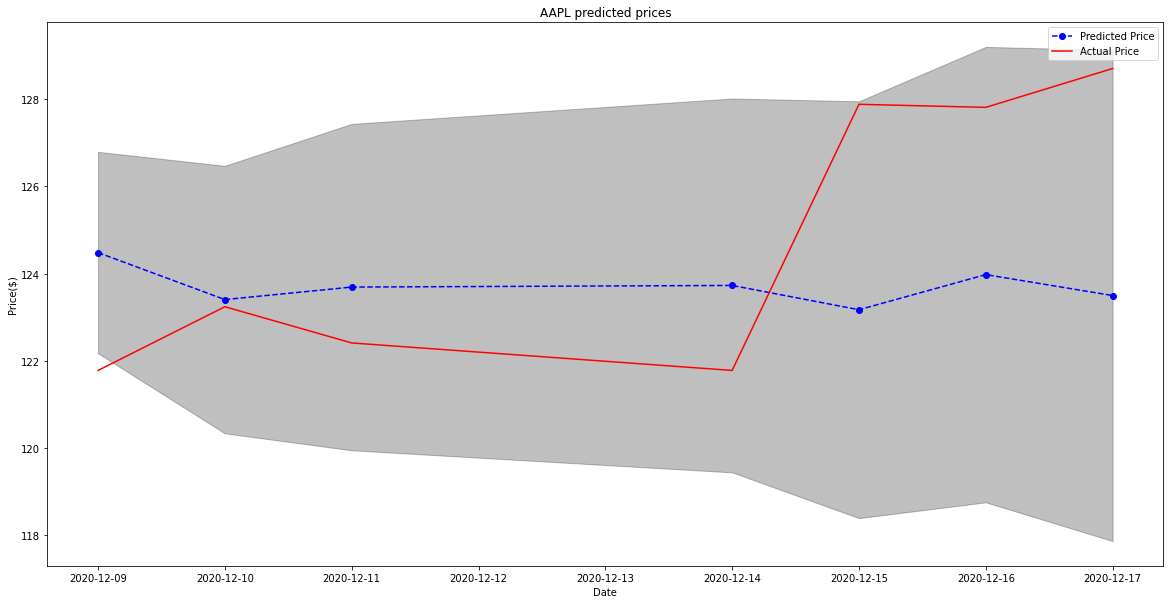

In [8]:
df = web.DataReader(company, data_source='yahoo', start='2014-01-01', end= '2020-12-17')
df = df.filter(['Close'])

test_set_range = df[int(len(df) - n_step_forecast):].index
test_set = df[int(len(df) - n_step_forecast):]

plt.figure(figsize = (20, 10))
plt.plot(test_set_range, pred_uc.predicted_mean, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_set, color='red', label='Actual Price')
plt.fill_between(test_set_range,
                 pred_ci[:, 0],
                 pred_ci[:, 1], color='k', alpha=.25)
plt.title(f'{company} predicted prices')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.legend()
plt.show()

In [ ]:
test_set_range = df[int(len(df) - n_step_forecast):].index


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth)

upload_file='D:\\utility\\ACOS_theoretical part.txt'
gfile = drive.CreateFile({'parents': [{'id': '1kxtGrwVl0gscMq79quvISHmXhUg4ZDUZ'}]})
# Read file and set it as the content of this instance.
gfile.SetContentFile(upload_file)
gfile.Upload() # Upload the file.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=1024156552763-pgnvjak1d8p41ph9aeabgd5rp9a75mnn.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

